# Intro

The purpose of this notebook is to process the GeoTIFFs that represent the historical set of GIPL outputs for the IEM domain. These data were driven by CRU TS 4.0 meterology and span the years 1901 through 2015. The native spatial resolution is 1 km. We will process all variables, except Mean Annual Ground Temperature (MAGT) at the depth of 4 m because those data are missing at this time. Also note that the talik variable does not have data for the initial year of 1901 either. Variables include:

 - Mean Annual Surface Temperature (deg. C)
 - MAGT at 0.5 m depth (deg. C)
 - MAGT at 1 m depth (deg. C)
 - MAGT at 2 m depth (deg. C)
 - MAGT at 3 m depth (deg. C)
 - MAGT at 5 m depth (deg. C)
 - Depth to Permafrost Base (m)
 - Depth to Permafrost Top (m)
 - Talik thickness (m)

These data have already been inflated to a working directory via the exploratory data analysis (EDA) work. 

In [1]:
from config import extracted_annual_dir

In [2]:
historical = [x for x in extracted_annual_dir.glob("*CRU*.tif")]
# there should be 115 years * 9 variables (minus 1901 talik thickness)
assert len(historical) == 115 * 9 - 1

gipl2_1km_CRU_TS4.0_Surf_1940.tif
Profile
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.4028234663852886e+38, 'width': 2560, 'height': 1861, 'count': 1, 'crs': CRS.from_epsg(3338), 'transform': Affine(1000.0, 0.0, -738286.4166,
       0.0, -1000.0, 2378458.0684), 'blockxsize': 128, 'blockysize': 128, 'tiled': True, 'interleave': 'band'}


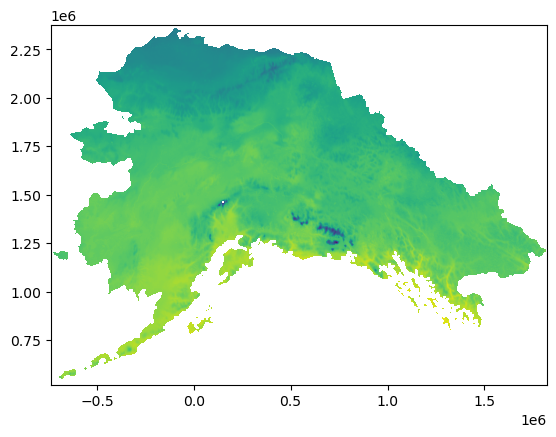

<AxesSubplot: >

In [3]:
# look at an example file
import random
import rasterio as rio
from rasterio.plot import show
random_tiff = random.choice(historical)
src = rio.open(random_tiff)
print(random_tiff.name)
print("Profile")
print(src.profile)
show(src)

Looks pretty good - pixel size is dead on 1 km, the data are EPSG:3338, and we can see the large extent of the IEM spatial domain. However, we will want to change the "nodata" value to -9999. It is also good practice to overwrite the CRS using the pyproj library - we do this to standardize the CRS description even if we don't need to reproject the data, like in this case here. Look at the following Well-Known Text for the random GeoTIFF from the dataset:

In [4]:
src.meta["crs"].to_wkt()

'PROJCS["NAD_1983_Albers",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4269"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",50],PARAMETER["longitude_of_center",-154],PARAMETER["standard_parallel_1",55],PARAMETER["standard_parallel_2",65],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'

And now compare to the Well-Known Text for the same CRS from the pyproj library:

In [5]:
from pyproj import CRS
epsg_3338 = CRS(3338)
epsg_3338.to_wkt()

'PROJCRS["NAD83 / Alaska Albers",BASEGEOGCRS["NAD83",DATUM["North American Datum 1983",ELLIPSOID["GRS 1980",6378137,298.257222101,LENGTHUNIT["metre",1]]],PRIMEM["Greenwich",0,ANGLEUNIT["degree",0.0174532925199433]],ID["EPSG",4269]],CONVERSION["Alaska Albers (meters)",METHOD["Albers Equal Area",ID["EPSG",9822]],PARAMETER["Latitude of false origin",50,ANGLEUNIT["degree",0.0174532925199433],ID["EPSG",8821]],PARAMETER["Longitude of false origin",-154,ANGLEUNIT["degree",0.0174532925199433],ID["EPSG",8822]],PARAMETER["Latitude of 1st standard parallel",55,ANGLEUNIT["degree",0.0174532925199433],ID["EPSG",8823]],PARAMETER["Latitude of 2nd standard parallel",65,ANGLEUNIT["degree",0.0174532925199433],ID["EPSG",8824]],PARAMETER["Easting at false origin",0,LENGTHUNIT["metre",1],ID["EPSG",8826]],PARAMETER["Northing at false origin",0,LENGTHUNIT["metre",1],ID["EPSG",8827]]],CS[Cartesian,2],AXIS["easting (X)",east,ORDER[1],LENGTHUNIT["metre",1]],AXIS["northing (Y)",north,ORDER[2],LENGTHUNIT["metre",1

So what we'll do is use the raster profile from the random GeoTIFF to create a new raster profile with updated values that we can use to create a batch of new GeoTIFFs.

In [6]:
out_profile = src.profile.copy()
out_profile

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.4028234663852886e+38, 'width': 2560, 'height': 1861, 'count': 1, 'crs': CRS.from_epsg(3338), 'transform': Affine(1000.0, 0.0, -738286.4166,
       0.0, -1000.0, 2378458.0684), 'blockxsize': 128, 'blockysize': 128, 'tiled': True, 'interleave': 'band'}

In [7]:
out_profile.update({"nodata": -9999,
                    "crs": epsg_3338})
out_profile

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999, 'width': 2560, 'height': 1861, 'count': 1, 'crs': <Derived Projected CRS: EPSG:3338>
Name: NAD83 / Alaska Albers
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - Alaska.
- bounds: (172.42, 51.3, -129.99, 71.4)
Coordinate Operation:
- name: Alaska Albers (meters)
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich
, 'transform': Affine(1000.0, 0.0, -738286.4166,
       0.0, -1000.0, 2378458.0684), 'blockxsize': 128, 'blockysize': 128, 'tiled': True, 'interleave': 'band'}

In [8]:
type(epsg_3338)

pyproj.crs.crs.CRS

The naming scheme on these isn't that bad either, for example `gipl2_1km_CRU_TS4.0_magt_2m_1958.tif`.
I think the only changes we need to make are:
 - scrub the "1km"" string - this does not vary at all in the dataset and the GeoTIFF retains this information anyway
 - let the scenario be a string with out underscores, like "CRU-TS4.0"
 - and let variable also be a string without underscores
 - use the naming template gipl_CRU-TS_variable_year_unit.tif 
 
We can use a few functions to parse the relevant information from each filename.

In [9]:
import re

def get_re_year(fp):
    """Fetch a single year (YYYY) from a file name."""
    year = re.match(r'.*([1-3][0-9]{3})', fp).group(1)
    return year


def get_re_depth(fp):
    """Fetch depth from a file name for mean annual ground temperature (magt) variables."""
    try:
        depth = re.match(r'.*magt_(0.5|1|2|3)m_', fp).group(1)
    except:
        depth = "5"
    return depth


def get_re_permafrost_var(fp):
    """Fetch the permafrost variable from a file name."""
    if "surf" in fp:
        depth = "surface_"
        pf_var = f"magt{depth}degC_"
    elif "magt" in fp:
        depth = get_re_depth(fp) + "m_"
        pf_var = f"magt{depth}degC_"
    elif "talik" in fp:
        pf_var = "talikthickness_m_"
    elif "base" in fp:
        pf_var = "permafrostbase_m_"
    elif "top" in fp:
        pf_var = "permafrosttop_m_"
    return pf_var


def create_new_filename(original_fp):
        fp_name = original_fp.name.lower()
        new_fname = f"gipl2_CRU-TS4.0_{get_re_permafrost_var(fp_name)}{get_re_year(fp_name)}.tif"
        return new_fname


In [39]:
for x in range(10):
    random_tiff = random.choice(historical)
    print(f"{random_tiff.name} becomes {create_new_filename(random_tiff)}")

gipl2_1km_CRU_TS4.0_magt_0.5m_1928.tif becomes gipl2_CRU-TS4.0_magt0.5m_degC_1928.tif
gipl2_1km_CRU_TS4.0_magt_5m_1907.tif becomes gipl2_CRU-TS4.0_magt5m_degC_1907.tif
gipl2_1km_CRU_TS4.0_magt_3m_1987.tif becomes gipl2_CRU-TS4.0_magt3m_degC_1987.tif
gipl2_1km_CRU_TS4.0_pfBase_1953.tif becomes gipl2_CRU-TS4.0_permafrostbase_m_1953.tif
gipl2_1km_CRU_TS4.0_magt_2m_1967.tif becomes gipl2_CRU-TS4.0_magt2m_degC_1967.tif
gipl2_1km_CRU_TS4.0_magt_0.5m_1990.tif becomes gipl2_CRU-TS4.0_magt0.5m_degC_1990.tif
gipl2_1km_CRU_TS4.0_Surf_2004.tif becomes gipl2_CRU-TS4.0_magtsurface_degC_2004.tif
gipl2_1km_CRU_TS4.0_magt_1m_1956.tif becomes gipl2_CRU-TS4.0_magt1m_degC_1956.tif
gipl2_1km_CRU_TS4.0_Talik_2010.tif becomes gipl2_CRU-TS4.0_talikthickness_m_2010.tif
gipl2_1km_CRU_TS4.0_Surf_2007.tif becomes gipl2_CRU-TS4.0_magtsurface_degC_2007.tif


That seems pretty good. We'll now open every file, generate the new filename, remap the nodata values to -9999, and then use the updated raster profile to write a brand new GeoTIFF.

In [40]:
import tqdm
from multiprocessing import Pool
from config import output_dir

def get_array_values(fp):
    with rio.open(fp) as src:
        arr_values = src.read(1)
    return arr_values


def fix_nodata_values(arr):
    arr[arr == src.meta["nodata"]] = -9999
    return arr


def write_new_geotiff(out_fp, arr):
    """Create new GeoTIFF using raster creation profile `out_profile`"""
    with rio.open(out_fp, "w", **out_profile) as dst:
        dst.write(arr, 1)


def run_new_geotiffs(args):
    in_fp, out_fp = args
    write_new_geotiff(out_fp, fix_nodata_values(get_array_values(in_fp)))
    return


def make_permafrost_dataset(original_fps):
    
    args = []
    for raster_src in original_fps:
        
        args.append((
            raster_src,
            output_dir.joinpath(create_new_filename(raster_src)),
        ))
    with Pool(32) as pool:
        for _ in tqdm.tqdm(
            pool.imap_unordered(run_new_geotiffs, args), total=len(args)
        ):
            pass
    del pool # superstitious deletion of the Pool object to avoid multiprocessing deadlocks
    return

In [41]:
make_permafrost_dataset(historical)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1034/1034 [00:50<00:00, 20.31it/s]


In [14]:
processed = [x for x in output_dir.glob("*CRU*.tif")]
assert len(historical) == 115 * 9 - 1 == len(processed)

Nice. We'll QC this data and archive the outputs in another notebook.